# learning-AI101 : raisin classification
### 건포도 데이터를 SVM, random forest, decision tree, KNN, logistic regression 기법을 적용하여 classification 및 Dense layer struction을 통한 DNN 방식의 classification

<br>

- **임규연 (lky473736)**
- 2024.07.14. ~ 2024.07.17.에 ML 작성, 2024.07.30.에 DL 작성
- **dataset** : https://archive.ics.uci.edu/dataset/850/raisin
- **data abstract** : Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.

------


## ML <a class='anchor' id='ml'>

machine learning으로 raisin을 classification한다. 목차는 아래와 같다.

- **1. 데이터 EDA (탐색적 데이터 분석)**
- **2. 데이터 전처리**
- **3. 각종 모델을 적용하여 classification**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

classification을 진행하기 전, 데이터 구조를 파악한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 feature에 대한 box plot 시각화
    - target의 도수를 bar plot 시각화

#### 1-1) 파일 열기, 기초 통계량 분석 및 classifiaction 전략 도출

In [2]:
# 파일 열기

df = pd.read_excel('../data/Raisin_Dataset/Raisin_Dataset.xlsx')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [3]:
# df의 행의 갯수, 열의 갯수, feature 파악

df.shape, df.columns

((900, 8),
 Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'Extent', 'Perimeter', 'Class'],
       dtype='object'))

In [4]:
# df의 기본적인 통계량 수치 파악, 각 열마다 결측치 여부 파악

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Area의 데이터 타입 :  int64
MajorAxisLength의 데이터 타입 :  float64
MinorAxisLength의 데이터 타입 :  float64
Eccentricity의 데이터 타입 :  float64
ConvexArea의 데이터 타입 :  int64
Extent의 데이터 타입 :  float64
Perimeter의 데이터 타입 :  float64
Class의 데이터 타입 :  object


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


범위와 척도를 통일하기 위하여 정수형인 'Area' 열과 'ConvexArea' 열을 **연속형으로 변경**할 예정이다. 각 feature가 의미하는 바와 그에 따른 classification 전략은 아래와 같다.

- **Area**
  - 건포도의 전체 면적
  - 정수형, min과 max의 차이가 커서 분포가 넓다.
  - mean이 median보다 작기 때문에 우측 편향일 가능성이 있다.

- **MajorAxisLength**
  - 주축 길이
  - 연속형, mean이 median보다 작기 때문에 우측 편향일 가능성이 있다.

- **MinorAxisLength**
  - 단축 길이
  - 연속형, 주축 길이보다는 min과 max의 차이가 작아 분포가 좁다.

- **Eccentricity**
  - 이심율
  - 연속형, 0에서 1 사이의 값을 가지면서 median이 0.7에 가까운 것을 보아 건포도가 타원형임을 알 수 있다. 

- **ConvexArea**
  - 볼록한 껍질의 면적
  - 정수형, 우측 편향일 가능성이 있다.

- **Extent**
  - 가장 작은 볼록한 껍질의 면적
  - 연속형, 평균과 중앙값이 거의 일치한다.

- **Perimeter**
  - 건포도에 의해 형성된 영역의 둘레를 바운딩 박스 내 총 픽셀 수로 나눈 비율
  - 연속형, Area와 유사한 분포를 보인다.

- **Class**
  - Kecimen과 Besni 건포도를 구분
  - 범주형, target 데이터

<br>

- **classification 전략**
    - 'Class' 열을 target data로 선정하고, 나머지 열을 feature로 삼아 classification하자.
    - 데이터를 아래와 같이 준비
        - 특성 변수(Feature): Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, Extent, Perimeter
        - 타겟 변수(Target): Class
    - SVM, KNN, logistic regression 전에 StandardScaler를 통한 스케일링이 필요

#### 1-2) seaborn을 통한 상관관계 heatmap 및 전체 histplot 시각화

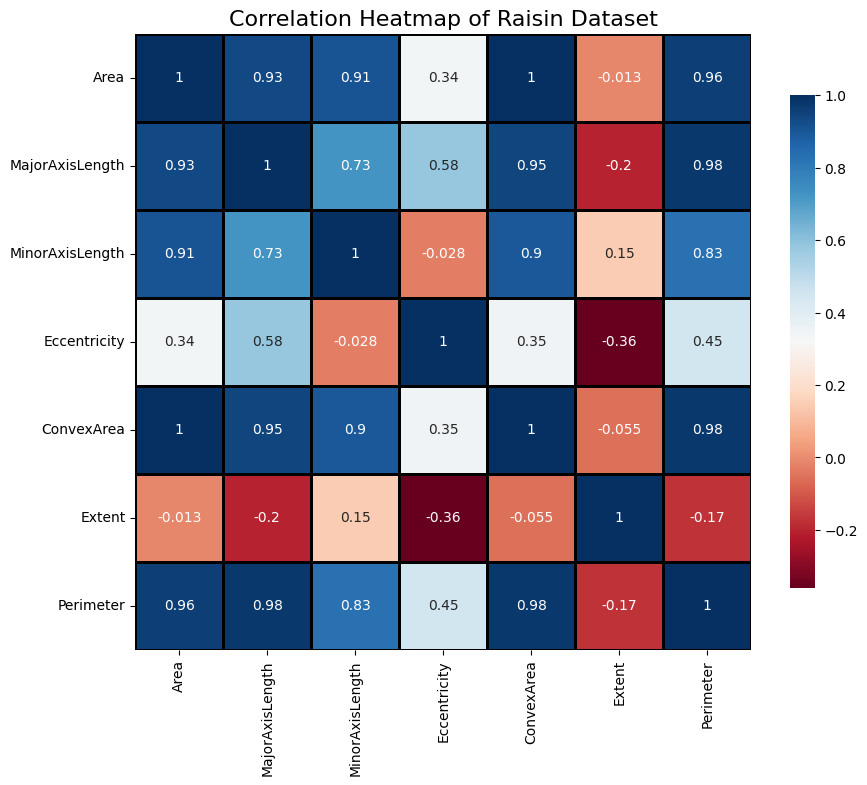

In [5]:
# seaborn을 통하여 heatmap 시각화
# 상관계수 행렬, 각 변수 간의 선형적 관계를 시각적으로 표시

correlation_matrix = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'Extent', 'Perimeter']].corr() # feature (target 제외)
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Raisin Dataset', fontsize=16)
plt.show()

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.

- **높은 상관관계**
     - Area와 ConvexArea (1.0): 두 변수는 완벽한 양의 상관관계를 가지고 있다. 이는 ConvexArea가 Area와 매우 유사한 정보를 담고 있다. 따라서 추후 모델링 과정에서 두 특성 중 하나만 사용해도 될 것으로 추측된다.
     - Area와 Perimeter (0.96): 면적과 둘레 사이에 매우 높은 양의 상관관계를 가지고 있다. 그러면 큰 면적을 가진 건포도가 둘레도 길 것이다.
     - MajorAxisLength와 Perimeter (0.98): 주축 길이와 둘레 사이에 매우 높은 양의 상관관계를 가진다.
     - MajorAxisLength와 ConvexArea (0.95): 주축 길이와 ConvexArea 사이에 높은 양의 상관관계를 가진다.
     - Area와 MajorAxisLength (0.93), Area와 MinorAxisLength (0.91): 면적이 클수록 주축과 단축 길이가 길어진다.
     
- **낮은 상관관계**
    - Extent와 대부분의 다른 변수들: Extent는 다른 대부분의 변수들과 상관관계가 매우 낮다. 특히 Area (-0.013)와 거의 상관관계가 없다. 따라서 추후 모델링 과정에서 Extent를 제거하여도 큰 문제가 되지 않을 것으로 추측된다.
    - MinorAxisLength와 Eccentricity (-0.028): 단축 길이와 이심률 사이의 상관관계는 매우 낮다.

분석 과정 중 Area와 ConvexArea 중 하나를 제거하는 여부 및 Extent의 제거 여부에 따른 학습 score의 변화를 logistic regression 분석 시 확인해보자.

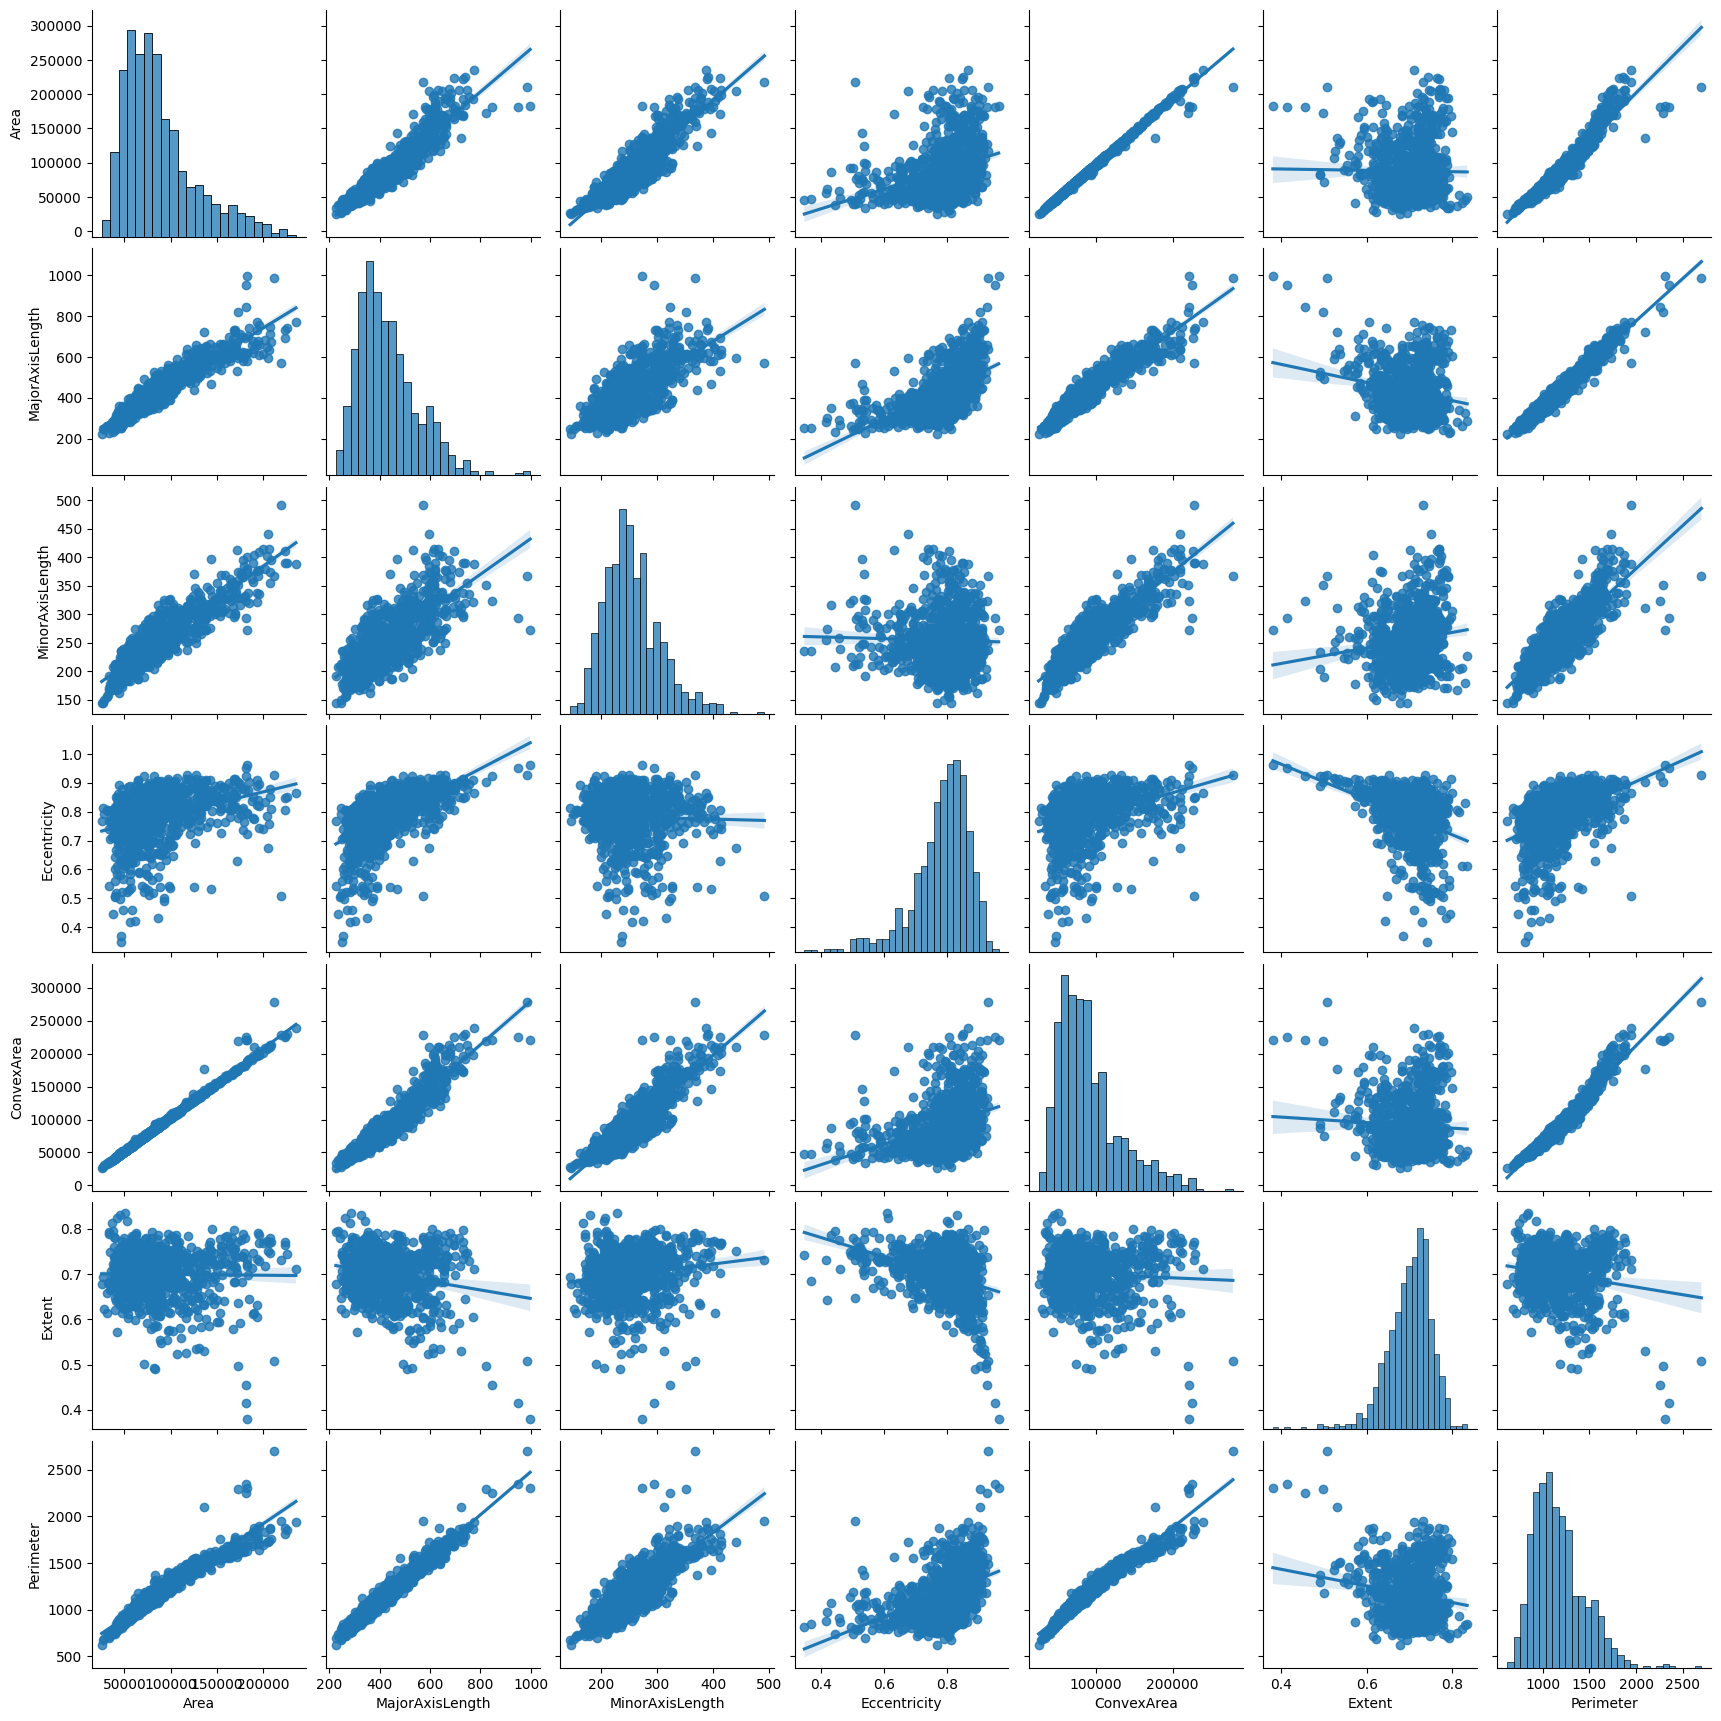

In [6]:
# seaborn을 통하여 pairplot 시각화
# 현재 데이터프레임의 모든 열 쌍에 대한 산점도와 히스토그램을 시각화한다

sns.pairplot(df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'Extent', 'Perimeter']], kind="reg") # feature (target 제외)
plt.show()

------

#### 1-3) 각 feature에 대한 box plot 시각화



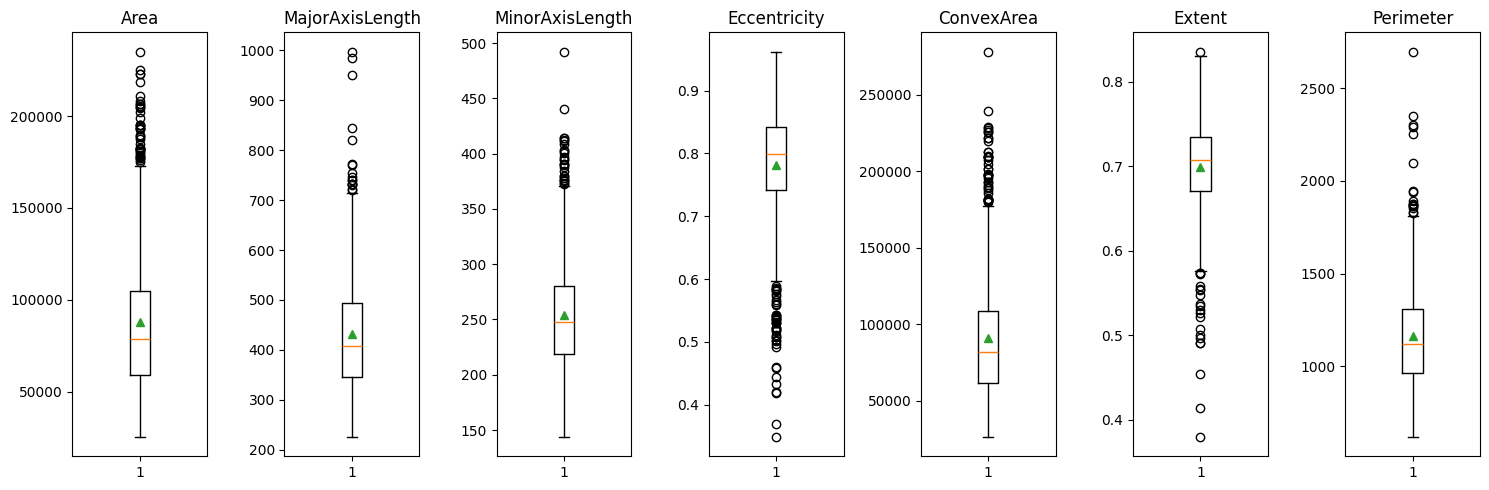

In [7]:
# box plot 그려 데이터 분포 확인

attr_list = ['Area', 'MajorAxisLength', 'MinorAxisLength', 
             'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=len(attr_list), figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(attr_list) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

------

#### 1-4) target의 갯수를 bar plot으로 시각화



In [8]:
# bar plot 그려 target의 class의 도수를 파악
# 도수를 알기 위해 unique 매소드 사용

target = np.unique(df['Class'])
print (target)

['Besni' 'Kecimen']


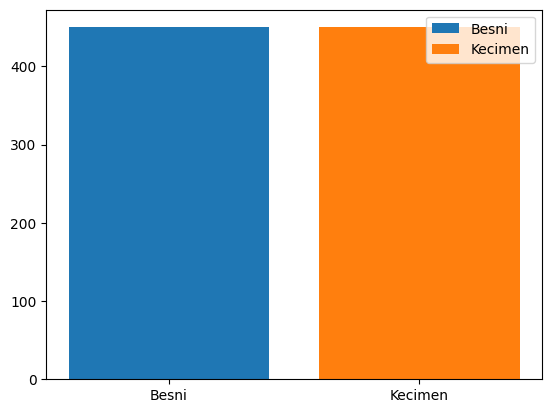

In [9]:
# 시각화 진행

plt.bar('Besni', len(df[df['Class'] == 'Besni']), label='Besni')
plt.bar('Kecimen', len(df[df['Class'] == 'Kecimen']), label='Kecimen')
plt.legend()
plt.show()

위 bar plot을 확인해보니 두 class 각각의 도수가 동일한 것을 확인할 수 있다. 따라서 샘플링 편향은 일어나지 않을 것이다.

------

### 2. 데이터 전처리

1에서 분석한 바를 토대로 전처리를 진행한다.
- **전처리**
    - 결측치는 그 feature (열)의 평균으로 fill
    - 이상치는 제거 
    - 만약 scale이 많이 다르다면 Z-score normalization 진행 

#### 2-1) 결측치 확인 및 fill 

In [10]:
# 결측치 확인

for feature in df.columns :
    print (f'{feature}열의 결측치 존재 여부 : ', df[feature].isnull())
    print ('\n--------------\n')

print ("데이터의 총 결측치 수 : ", df.isnull().sum())

Area열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: Area, Length: 900, dtype: bool

--------------

MajorAxisLength열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: MajorAxisLength, Length: 900, dtype: bool

--------------

MinorAxisLength열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: MinorAxisLength, Length: 900, dtype: bool

--------------

Eccentricity열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: Eccentricity, Length: 900, dtype: bool

--------------

ConvexArea열의 결측치 존재 여부 :  0      False
1      False
2      False
3      

위를 보면, 본 데이터에 결측치가 **전혀** 존재하지 않고 있다. 따라서 결측치에 따른 전처리를 진행하지 않아도 된다.

#### 2-2) 정규화 (normalization) - Z-score normalization
- 각 feature의 scale이 서로 달라, SVM, KNN, logistic regression 전에 StandardScaler를 통한 스케일링이 필요
- 따라서 StandardScaler를 통한 Z-score normalization을 수행

In [11]:
# input과 target으로 df를 split

raisin_input = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 
             'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']].to_numpy() 
raisin_target = df['Class'].to_numpy()

In [12]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(raisin_input, raisin_target, 
                                                   stratify=raisin_target, 
                                                   test_size=0.2)

In [13]:
# StandardScaler을 통한 정규화 진행

from sklearn.preprocessing import StandardScaler
ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)

-------

### 3. 각종 모델을 적용하여 classification
- SVM, random forest, decision tree, KNN, logistic regression 기법을 적용하여 classification
- 순서는 KNN, logistic regression, decision tree, random forest, SVM
    - 각 모델마다 fit, score, (hyperparameter가 변경되었을 때 score) 시각화, predict 순으로 진행
    - predict set은 chatGPT을 이용하여 예시 데이터 get, 아래와 같은 데이터를 모델에 대입할 예정
        - 1번 데이터 : 'Area': 87524, 'MajorAxisLength': 442.2, 'MinorAxisLength': 253.3, 'Eccentricity': 0.82, 'ConvexArea': 90546, 'Extent': 0.76, 'Perimeter': 1184.0
            - label : Besni
        - 2번 데이터 : 'Area': 86520, 'MajorAxisLength': 430.0, 'MinorAxisLength': 245.0, 'Eccentricity': 0.81, 'ConvexArea': 89530, 'Extent': 0.75, 'Perimeter': 1165.5
            - label : Besni
        - 3번 데이터 : 'Area': 88000, 'MajorAxisLength': 445.5, 'MinorAxisLength': 255.0, 'Eccentricity': 0.83, 'ConvexArea': 91000, 'Extent': 0.77, 'Perimeter': 1190.3
            - label : Besni
        - 4번 데이터 : 'Area': 87000, 'MajorAxisLength': 435.0, 'MinorAxisLength': 250.5, 'Eccentricity': 0.82, 'ConvexArea': 90000, 'Extent': 0.76, 'Perimeter': 1175.0
            - label : Besni
        - 5번 데이터 : 'Area': 87800, 'MajorAxisLength': 440.0, 'MinorAxisLength': 252.0, 'Eccentricity': 0.82, 'ConvexArea': 90700, 'Extent': 0.76, 'Perimeter': 1182.0
            - label : Besni

In [14]:
# predict_X를 선언한다

predict_X = [
    [87524, 442.2, 253.3, 0.82, 90546, 0.76, 1184.0],
    [86520, 430.0, 245.0, 0.81, 89530, 0.75, 1165.5],
    [88000, 445.5, 255.0, 0.83, 91000, 0.77, 1190.3],
    [87000, 435.0, 250.5, 0.82, 90000, 0.76, 1175.0],
    [87800, 440.0, 252.0, 0.82, 90700, 0.76, 1182.0]
]

#### 3-1) KNN
- n_neighbors을 3부터 450까지 바꾸어 가면서 학습하여 최적의 하이퍼파라미터를 도출 (overfitting, underfitting을 막기 위함)
- 예시 데이터를 predict 메소드에 대입하여 실제 분류 성공율이 얼마인지 테스트

In [15]:
# KNN을 활용한 모델 fit 및 train score, test score 출력
# 이때, n_neighbors 하이퍼파라미터를 조정해나가면서, 점수를 get

from sklearn.neighbors import KNeighborsClassifier

score_list = [] # [n_neighbors, [train score, test score]]

# n_neighbors를 3부터 450까지 진행 -> 데이터의 절반 (900/2 = 450)까지 값을 테스트하여 최적의 값 찾기

for num in range (3, 451) :
    knn = KNeighborsClassifier(n_neighbors=num)
    knn.fit (X_train_scaled, y_train)
    
    current_score = [num, [knn.score(X_train_scaled, y_train),
                             knn.score(X_test_scaled, y_test)]]
    score_list.append (current_score)
    print (f'n_neighbors : {num} | train score : {current_score[1][0]}, test score : {current_score[1][1]}')

n_neighbors : 3 | train score : 0.9097222222222222, test score : 0.8277777777777777
n_neighbors : 4 | train score : 0.9027777777777778, test score : 0.8222222222222222
n_neighbors : 5 | train score : 0.8916666666666667, test score : 0.8277777777777777
n_neighbors : 6 | train score : 0.8875, test score : 0.8222222222222222
n_neighbors : 7 | train score : 0.8833333333333333, test score : 0.8277777777777777
n_neighbors : 8 | train score : 0.8861111111111111, test score : 0.8388888888888889
n_neighbors : 9 | train score : 0.8805555555555555, test score : 0.85
n_neighbors : 10 | train score : 0.8833333333333333, test score : 0.8333333333333334
n_neighbors : 11 | train score : 0.8722222222222222, test score : 0.8444444444444444
n_neighbors : 12 | train score : 0.8708333333333333, test score : 0.8611111111111112
n_neighbors : 13 | train score : 0.8680555555555556, test score : 0.8666666666666667
n_neighbors : 14 | train score : 0.8694444444444445, test score : 0.8722222222222222
n_neighbors :

n_neighbors : 104 | train score : 0.8541666666666666, test score : 0.8611111111111112
n_neighbors : 105 | train score : 0.8541666666666666, test score : 0.8555555555555555
n_neighbors : 106 | train score : 0.8555555555555555, test score : 0.8555555555555555
n_neighbors : 107 | train score : 0.8555555555555555, test score : 0.8444444444444444
n_neighbors : 108 | train score : 0.8555555555555555, test score : 0.8555555555555555
n_neighbors : 109 | train score : 0.8541666666666666, test score : 0.8555555555555555
n_neighbors : 110 | train score : 0.8555555555555555, test score : 0.8611111111111112
n_neighbors : 111 | train score : 0.8527777777777777, test score : 0.8666666666666667
n_neighbors : 112 | train score : 0.8527777777777777, test score : 0.8611111111111112
n_neighbors : 113 | train score : 0.8527777777777777, test score : 0.8555555555555555
n_neighbors : 114 | train score : 0.8555555555555555, test score : 0.8611111111111112
n_neighbors : 115 | train score : 0.8555555555555555, 

n_neighbors : 204 | train score : 0.8513888888888889, test score : 0.8388888888888889
n_neighbors : 205 | train score : 0.8513888888888889, test score : 0.8388888888888889
n_neighbors : 206 | train score : 0.8541666666666666, test score : 0.8444444444444444
n_neighbors : 207 | train score : 0.8555555555555555, test score : 0.8388888888888889
n_neighbors : 208 | train score : 0.8555555555555555, test score : 0.8388888888888889
n_neighbors : 209 | train score : 0.8541666666666666, test score : 0.8388888888888889
n_neighbors : 210 | train score : 0.8555555555555555, test score : 0.8388888888888889
n_neighbors : 211 | train score : 0.8541666666666666, test score : 0.8388888888888889
n_neighbors : 212 | train score : 0.8541666666666666, test score : 0.8388888888888889
n_neighbors : 213 | train score : 0.8527777777777777, test score : 0.8388888888888889
n_neighbors : 214 | train score : 0.8513888888888889, test score : 0.8388888888888889
n_neighbors : 215 | train score : 0.8527777777777777, 

n_neighbors : 303 | train score : 0.8430555555555556, test score : 0.8277777777777777
n_neighbors : 304 | train score : 0.8430555555555556, test score : 0.8277777777777777
n_neighbors : 305 | train score : 0.8416666666666667, test score : 0.8222222222222222
n_neighbors : 306 | train score : 0.8416666666666667, test score : 0.8222222222222222
n_neighbors : 307 | train score : 0.8416666666666667, test score : 0.8222222222222222
n_neighbors : 308 | train score : 0.8416666666666667, test score : 0.8277777777777777
n_neighbors : 309 | train score : 0.8416666666666667, test score : 0.8222222222222222
n_neighbors : 310 | train score : 0.8416666666666667, test score : 0.8277777777777777
n_neighbors : 311 | train score : 0.8430555555555556, test score : 0.8277777777777777
n_neighbors : 312 | train score : 0.8416666666666667, test score : 0.8277777777777777
n_neighbors : 313 | train score : 0.8430555555555556, test score : 0.8277777777777777
n_neighbors : 314 | train score : 0.8444444444444444, 

n_neighbors : 402 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 403 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 404 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 405 | train score : 0.8291666666666667, test score : 0.8055555555555556
n_neighbors : 406 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 407 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 408 | train score : 0.8319444444444445, test score : 0.8055555555555556
n_neighbors : 409 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 410 | train score : 0.8305555555555556, test score : 0.8055555555555556
n_neighbors : 411 | train score : 0.8291666666666667, test score : 0.8055555555555556
n_neighbors : 412 | train score : 0.8291666666666667, test score : 0.8055555555555556
n_neighbors : 413 | train score : 0.8263888888888888, 

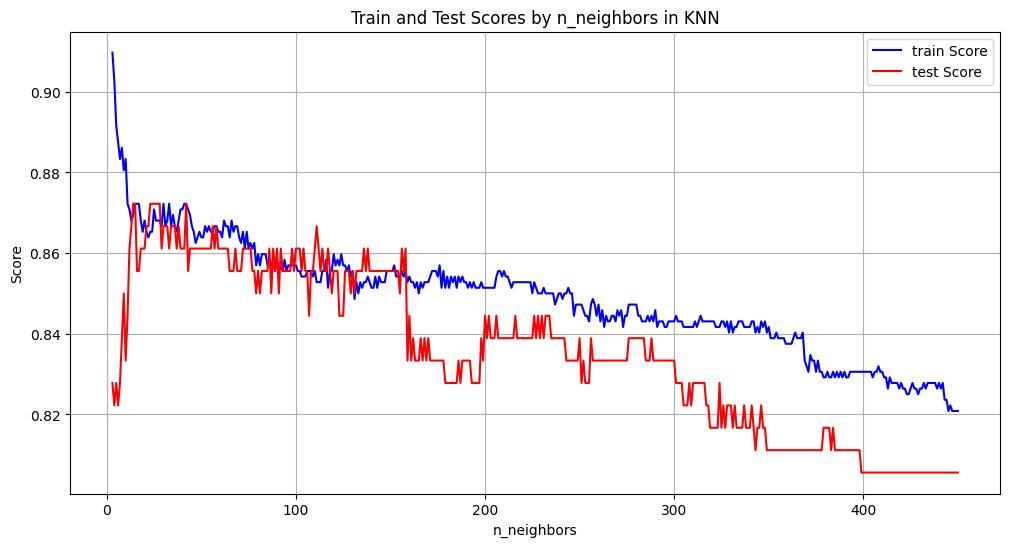

In [16]:
# 위 결과를 시각화화여 가장 적합한 n_neighbors 파라미터를 찾는다

n_neighbors_values = [score[0] for score in score_list] # n_neighbors
train_scores = [score[1][0] for score in score_list] # train score
test_scores = [score[1][1] for score in score_list] # test score

plt.figure(figsize=(12, 6))
plt.plot(n_neighbors_values, train_scores, label='train Score', color='blue')
plt.plot(n_neighbors_values, test_scores, label='test Score', color='red')
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title('Train and Test Scores by n_neighbors in KNN')
plt.legend()
plt.grid(True)
plt.show()

위 figure을 보고 아래와 같이 분석 가능하다.

- 1) 현재 train score은 n_neighbors 하이퍼파라미터가 증가함에 따라 감소하는 우하향의 추세를 보인다.
- 2) test score은 100대 후반에서 최고점을 보이다가 train score 추세선과 비슷한 양상으로 우하향한다.
- 3) 매우 흥미로운 것은, test score가 train score보다 높게 학습되는 구간이 존재한다.
    - 이 상황의 원인을 아래와 같이 유추해볼 수 있다.
        - 3-1) train data보다 test data에 모델이 더 잘 일반화되었을 수 있음.
        - 3-2) train set과 test set의 분포가 달라 발생한 상황일 수도 있음.

따라서 3번 분석에 해당되는 양상을 보이는 점을 제외하고, train score와 test score의 차이가 가장 적으면서, 그 점에 해당되는 n_neighbors 중 train score가 가장 높은 n_neighbors 하이퍼파라미터를 택하여 다시 학습을 진행한다.

In [17]:
# train score >= test score이면서 차이가 0.05 미만인 n_neighbors 찾기

optimal_point = [[compo[0], compo[1][0], abs(compo[1][0] - compo[1][1])] for compo in score_list if compo[1][0] >= compo[1][1]]

# 오차가 가장 적으면서, train score에 내림차순되게 정렬
optimal_point.sort (key = lambda x : (x[2], -x[1]))
print (optimal_point)
print ('train score >= test score이면서 차이가 가장 작고, n_neighbors 중 가장 train score가 높은 n_neighbors : ',
      optimal_point[0][0])

[[15, 0.8722222222222222, 0.0], [42, 0.8722222222222222, 0.0], [31, 0.8666666666666667, 0.0], [34, 0.8666666666666667, 0.0], [36, 0.8666666666666667, 0.0], [58, 0.8666666666666667, 0.0], [73, 0.8611111111111112, 0.0], [75, 0.8611111111111112, 0.0], [89, 0.8555555555555555, 0.0], [93, 0.8555555555555555, 0.0], [95, 0.8555555555555555, 0.0], [106, 0.8555555555555555, 0.0], [108, 0.8555555555555555, 0.0], [115, 0.8555555555555555, 0.0], [118, 0.8555555555555555, 0.0], [127, 0.8555555555555555, 0.0], [130, 0.8555555555555555, 0.0], [148, 0.8555555555555555, 0.0], [149, 0.8555555555555555, 0.0], [150, 0.8555555555555555, 0.0], [151, 0.8555555555555555, 0.0], [13, 0.8680555555555556, 0.001388888888888884], [32, 0.8680555555555556, 0.001388888888888884], [38, 0.8680555555555556, 0.001388888888888884], [47, 0.8625, 0.001388888888888884], [76, 0.8625, 0.001388888888888884], [85, 0.8569444444444444, 0.001388888888888884], [96, 0.8569444444444444, 0.001388888888888884], [97, 0.8569444444444444, 0

In [18]:
# n_neighbors=4으로 fit, score

knn = KNeighborsClassifier(n_neighbors=4)
knn.fit (X_train_scaled, y_train)
print (f"train score, test score : {knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)}")

train score, test score : (0.9027777777777778, 0.8222222222222222)


In [19]:
# predict

knn.predict(predict_X)

array(['Besni', 'Besni', 'Besni', 'Besni', 'Besni'], dtype=object)

100% 검증이 완료되어 classification이 제대로 된 것이라고 볼 수 있으나, train score와 test score가 기대에 비해 낮다. 따라서 추후 특성을 늘리는 PolynormialFeatures 메소드를 사용하여 특성간의 곱 및 자기특성의 제곱 항을 추가함으로써 학습율을 올릴 수 있다. 


#### 3-2) logistic regression
- logistic regression 모델을 사용하여 다중 분류를 진행한다.
- softmax 함수를 사용하여 feature 수만큼의 z값을 확률로 변환한다.
    - 직접 z값을 구하여 진행할 수 있으나, predict_proba 메소드를 사용하여 진행하도록 한다.
- hyperparameter인 C와 max_iter 중 최적값을 도출한다.
    - 최적의 hyperparameter를 찾기 위해 그리드 서치 기법을 사용한다.
    - 그리드는 아래와 같이 정의한다.
        - C : log scale로 10^-10 ~ 10^10 사이 20개의 수
        - max_iter : 100, 200, 300, 400, 500

In [20]:
# logistic regression 모델 fit 및 train score, test score 출력
# 이때, C와 max_iter 최적의 하이퍼파라미터를 찾기 위해 grid search 기법 사용

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 그리드 정의
param_grid = {
    'C': np.logspace(-10, 10, 20),
    'max_iter': [100, 200, 300, 400, 500]
}

# Logistic Regression 모델 정의
lr = LogisticRegression()

# Grid Search 설정
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit
grid_search.fit(X_train_scaled, y_train)

# 최적의 하이퍼파라미터 출력 및 score 출력
print(f'최적의 hyperparameter : {grid_search.best_params_}')
print(f'cross-validation score : {grid_search.best_score_}')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

최적의 hyperparameter : {'C': 0.026366508987303555, 'max_iter': 100}
cross-validation score : 0.8638888888888889


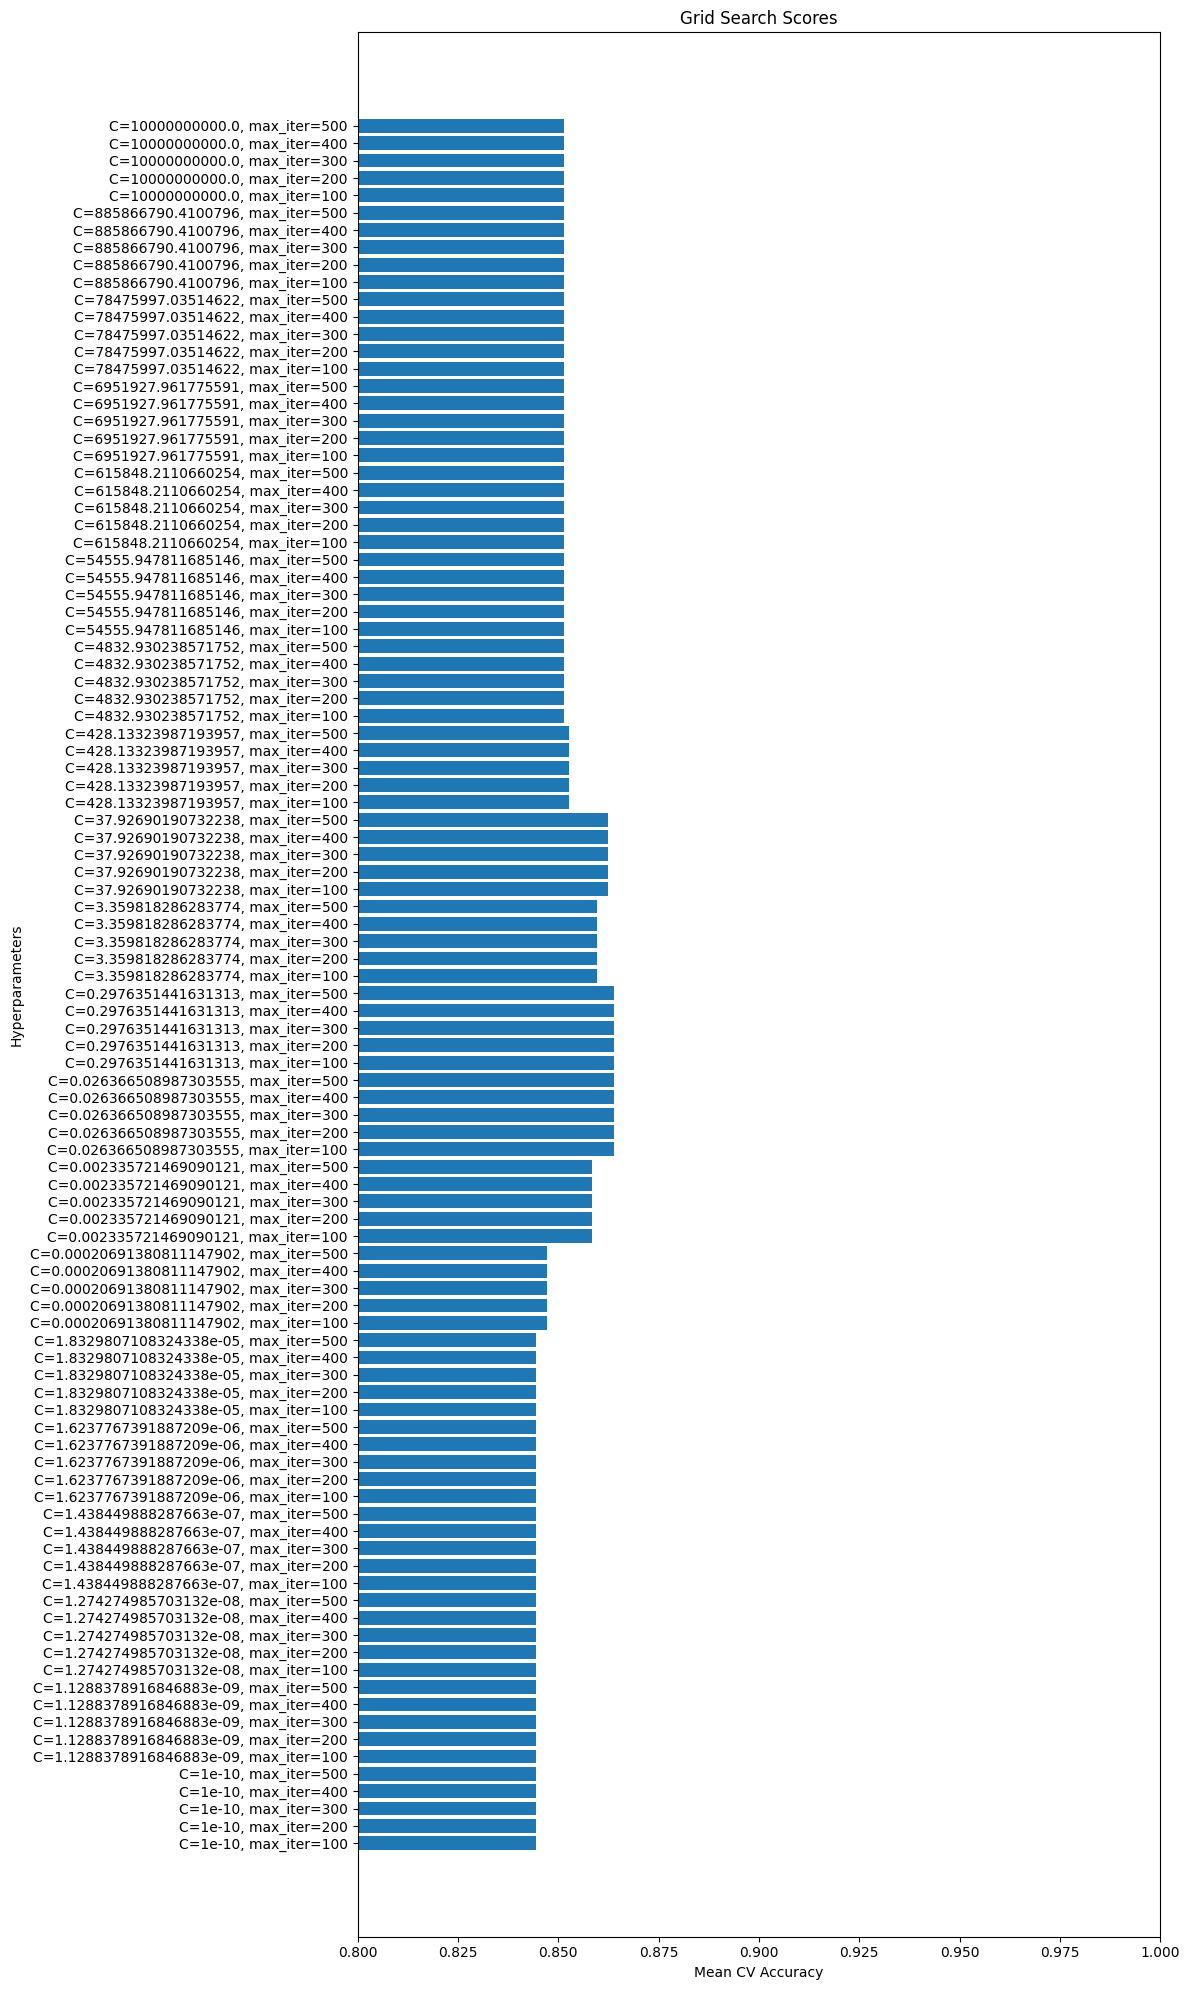

In [21]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
C_values = [params[i]['C'] for i in range(len(params))]
max_iter_values = [params[i]['max_iter'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"C={C}, max_iter={max_iter}" for C, max_iter in zip(C_values, max_iter_values)])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Grid Search Scores')
plt.xlim([0.8, 1.0])  # x 축 범위 설정 (필요에 따라 조정 가능)
plt.tight_layout()
plt.show()

In [22]:
# fit, score

lr = grid_search.best_estimator_
lr.fit (X_train_scaled, y_train)

lr_score = [lr.score(X_train_scaled, y_train), lr.score(X_test_scaled, y_test)]
print (f"train score, test score : {lr_score}")

train score, test score : [0.8666666666666667, 0.8666666666666667]


In [23]:
# predict

print(lr.predict(predict_X))
print(lr.predict_proba(predict_X))

['Besni' 'Besni' 'Besni' 'Besni' 'Besni']
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


100% 검증이 완료되어 classification이 제대로 된 것이라고 볼 수 있으나, 역시나 train score와 test score가 기대에 비해 낮다. 따라서 추후 특성을 늘리는 PolynormialFeatures 메소드를 사용하여 특성간의 곱 및 자기특성의 제곱 항을 추가함으로써 학습율을 올릴 수 있다.

**데이터 EDA (탐색적 데이터 분석)** 과정에서 heatmap을 이용한 각 feature간의 상관관계를 알아볼 때, 아래와 같은 분석을 실시한다고 언급한 바 있다.

- 분석 1) Area와 ConvexArea 중 하나를 제거
- 분석 2) Extent의 제거 여부에 따른 학습

왜냐하면 Area와 ConvexArea는 서로 상관관계가 1인 완벽한 양의 상관관계이므로 하나를 제거하여도 학습에 큰 지장이 없을 것이라고 판단하였다. 또한 Extent는 다른 변수들과 매우 미미한 상관관계를 가지고 있어 Extent 특성 하나 때문에 분류에 악영향을 끼치지 않을 것이라고 판단하였다.

하지만 분석 1의 근거는 모순이다. 그에 대한 까닭은, 단지 Area와 ConvexArea 둘 사이의 상관관계가 1이라고 하여 다른 변수들과의 관계가 이에 상응한다고 볼 수는 없다. 다른 변수들과의 상호작용이 중요하여 모델에서 고려해야 할 추가적 정보가 담겨있을 수 있기 때문에 그렇다.  

따라서 분석 2를 진행한다. 분석 2를 진행하여 Extent를 제거하지 않은 기존 score를 거의 유지하는 지를 확인할 것이다.

##### 3-2-exp) Extent의 제거 여부에 따른 학습
- Extent 열을 제거한 후에 학습 과정을 진행한다.
- 기존의 score와 제거한 후의 score 간의 차이를 확인한다.

- 순서는 아래와 같다.
    - (1) Extent 열을 제거한 상태에서 train set, test set을 만들기
    - (2) transformer를 이용한 스케일링 진행
    - (3) 그리드 서치 기법으로 최적의 C, max_iter 찾기
    - (4) fit, score

In [24]:
# (1) Extent 열을 제거한 상태에서 train set, test set을 만들기
# (2) -> transformer를 이용한 스케일링 진행
# (3) -> 그리드 서치 기법으로 최적의 C, max_iter 찾기
# (4) -> fit, score

# (1)
raisin_input_noExtent = raisin_input = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 
             'Eccentricity', 'ConvexArea', 'Perimeter']].to_numpy() 

X_train_noExtent, X_test_noExtent, y_train_noExtent, y_test_noExtent = train_test_split(raisin_input_noExtent, raisin_target, 
                                                   stratify=raisin_target, 
                                                   test_size=0.2)


# (2)
ss_transformer = StandardScaler()
ss_transformer.fit(X_train_noExtent)

X_train_scaled_noExtent = ss_transformer.transform(X_train_noExtent)
X_test_scaled_noExtent = ss_transformer.transform(X_test_noExtent)


# (3) 
param_grid = {
    'C': np.logspace(-10, 10, 20),
    'max_iter': [100, 200, 300, 400, 500]
}

lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled_noExtent, y_train_noExtent)

print(f'최적의 hyperparameter (noExtent) : {grid_search.best_params_}')
print(f'cross-validation score (noExtent) : {grid_search.best_score_}')


# (4) 
lr = LogisticRegression(C=grid_search.best_params_['C'], max_iter=grid_search.best_params_['max_iter'])
lr.fit (X_train_scaled_noExtent, y_train_noExtent)
lr_score_noExtent = [lr.score(X_train_scaled_noExtent, y_train_noExtent), lr.score(X_test_scaled_noExtent, y_test_noExtent)]


# 결과
print ('\n--------------\n')
print (f"train score, test score : {lr_score}")
print (f"train score, test score (noExtent) : {lr_score_noExtent}")

최적의 hyperparameter (noExtent) : {'C': 3.359818286283774, 'max_iter': 100}
cross-validation score (noExtent) : 0.8625

--------------

train score, test score : [0.8666666666666667, 0.8666666666666667]
train score, test score (noExtent) : [0.8652777777777778, 0.8777777777777778]


위와 같이 실험해 본 결과, Extent 열을 제거하였을 때 기존과 train score과 test score가 다르다는 것을 확인 가능하다. 아무리 미비한 상관관계를 가진 feature이라 할 지라도 학습 전체를 관장하였을 때는 학습에 참여하는 것이 더 효과적인 fitting이라는 것을 깨달았다.

#### 3-3) decision tree

- decision tree 모델을 사용하여 다중 분류를 진행한다.
- hyperparameter인 max_depth, min_samples_split, min_samples_leaf 중 최적값을 도출한다.
    - 최적의 hyperparameter를 찾기 위해 랜덤 서치 기법을 사용한다.

In [25]:
# DT를 활용한 모델 fit 및 train score, test score 출력
# 이때, 랜덤 서치 기법을 사용하여 최적의 hyperparameter 도출

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

param_grid = {'max_depth' : randint(20, 50), 
             'min_samples_split' : randint(2, 25), 
             'min_samples_leaf' : randint(1, 25)}

rs = RandomizedSearchCV(DecisionTreeClassifier(), param_grid, 
                        n_iter=100, n_jobs=-1)
rs.fit (X_train_scaled, y_train)

print ("최적의 hypterparamter : ", rs.best_params_)
print (f'cross-validation score : {rs.best_score_}')

최적의 hypterparamter :  {'max_depth': 25, 'min_samples_leaf': 17, 'min_samples_split': 15}
cross-validation score : 0.8388888888888889


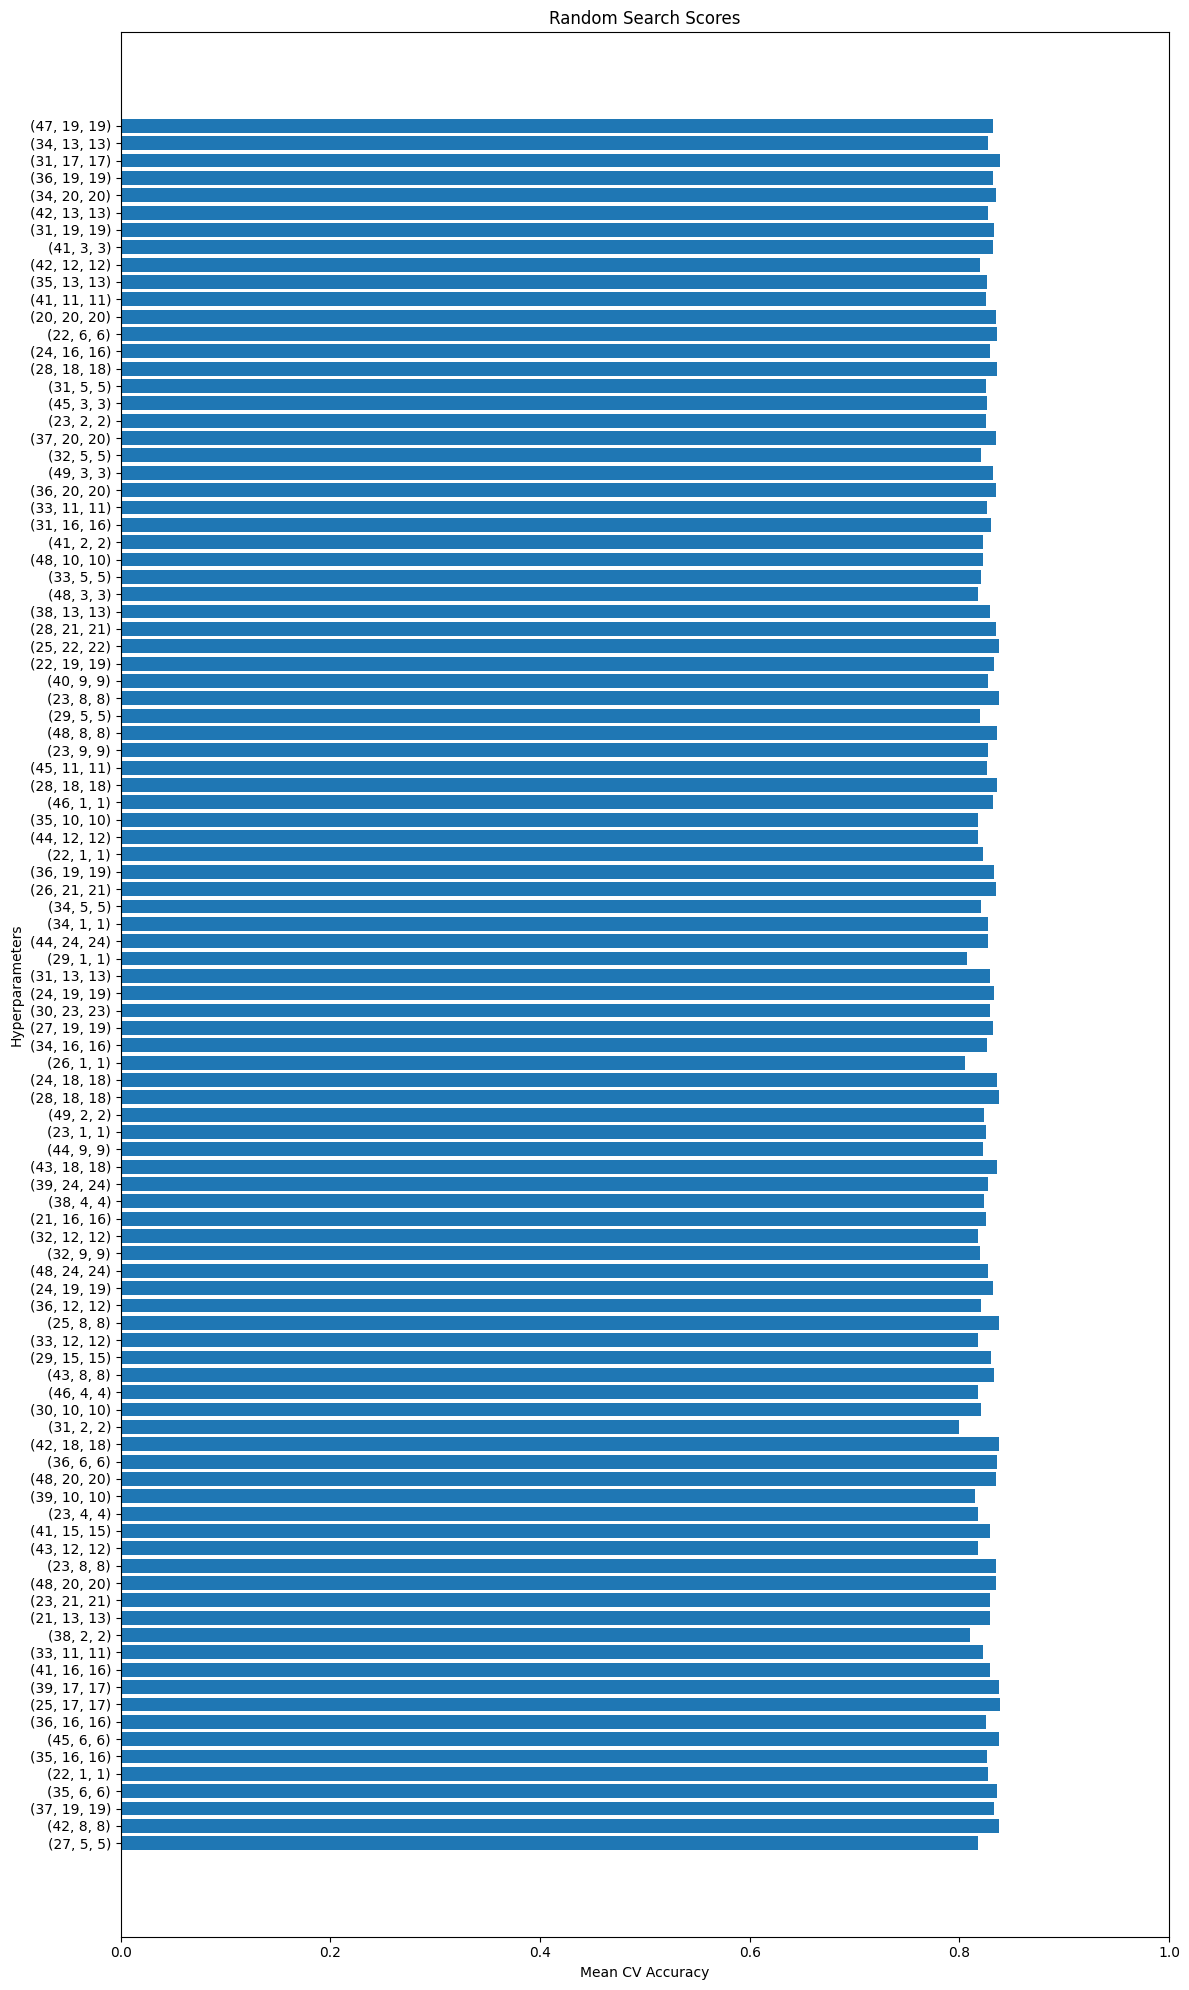

In [26]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
max_depth_values = [params[i]['max_depth'] for i in range(len(params))]
min_samples_split_values = [params[i]['min_samples_leaf'] for i in range(len(params))]
min_samples_leaf_values = [params[i]['min_samples_leaf'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(12, 20))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"{com1, com2, com3}" for com1, com2, com3 in zip(max_depth_values, min_samples_split_values, min_samples_leaf_values)])
ax.set_ylabel('Hyperparameters')
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim((0, 1))
plt.tight_layout()
plt.show()

In [27]:
# fit, score

dt = DecisionTreeClassifier(max_depth=34, min_samples_leaf=24, 
                           min_samples_split=18)
dt.fit (X_train_scaled, y_train)

dt_score = [dt.score(X_train_scaled, y_train), dt.score(X_test_scaled, y_test)]
print (f"train score, test score : {dt_score}")

train score, test score : [0.8763888888888889, 0.85]


In [28]:
# predict

print(dt.predict(predict_X))
print(dt.predict_proba(predict_X))

['Besni' 'Besni' 'Besni' 'Besni' 'Besni']
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


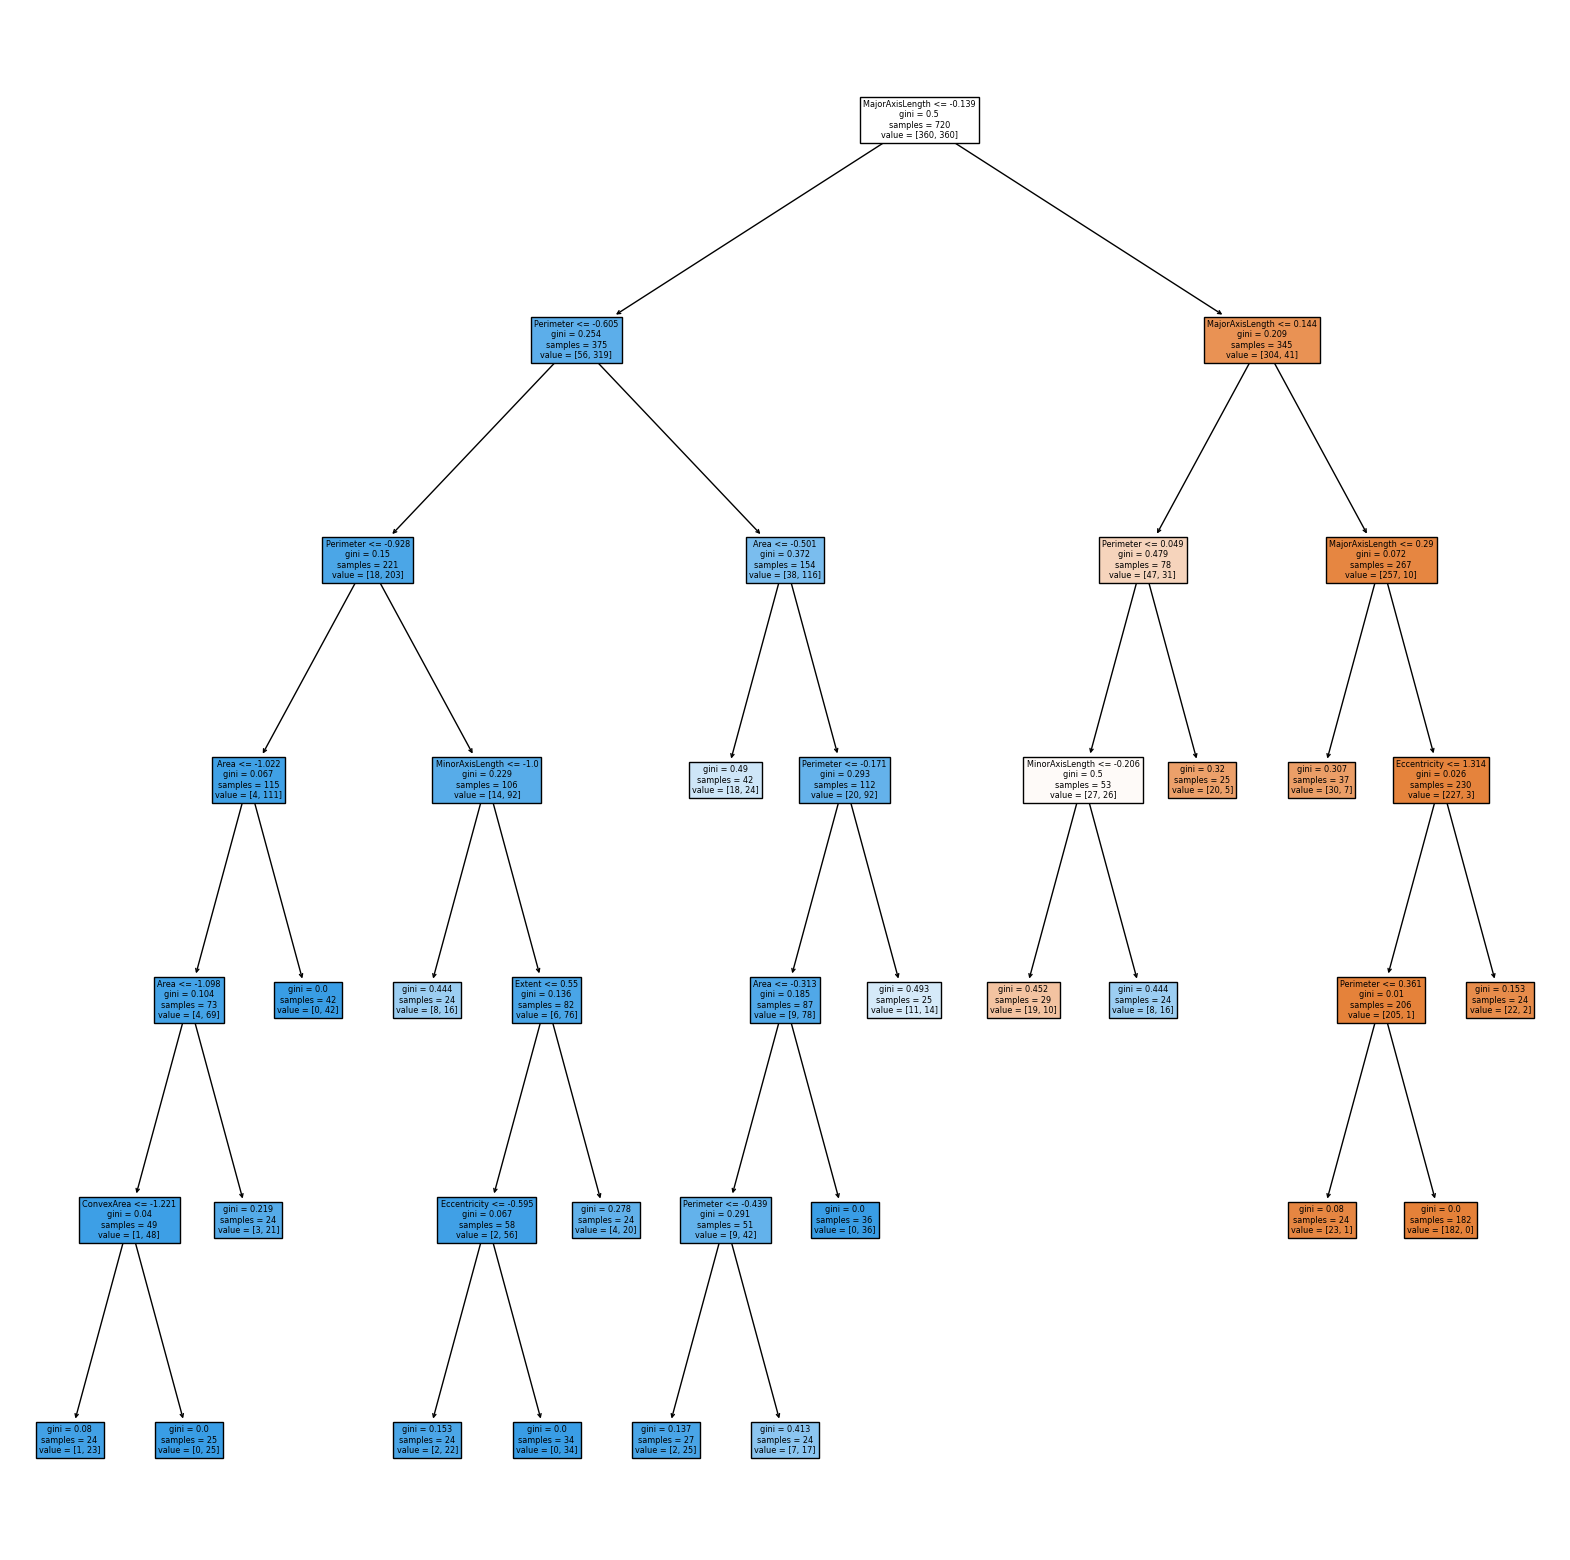

Area의 중요도 :  0.023857733069844067
MajorAxisLength의 중요도 :  0.8879053660419816
MinorAxisLength의 중요도 :  0.022118976524183945
Eccentricity의 중요도 :  0.0019448476496860842
ConvexArea의 중요도 :  0.0001796872349078321
Extent의 중요도 :  0.0025070736772661298
Perimeter의 중요도 :  0.06148631580213051


In [29]:
# tree 시각화

from sklearn.tree import plot_tree

plt.figure (figsize=(20, 20))
plot_tree(dt, filled=True, feature_names=['Area', 'MajorAxisLength', 'MinorAxisLength', 
             'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter'])
plt.show()

for i in range (7) : 
    print (f"{['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter'][i]}의 중요도 : ", dt.feature_importances_[i])

위 과정을 통하여 왼쪽에서는 양성 클래스, 오른쪽에서는 음성 클래스로 분리된 것을 확인 가능하고, 이를 통하여 가지치기가 명확히 수행되었다고 판단된다. 또한 각 feature의 중요도를 출력하여 그 중 MajorAxisLength가 본 tree의 질문 node 중 가장 중요도가 높은 것을 알 수 있다.

#### 3-4) random forest

In [30]:
# random forest를 통하여 classification
# fit, score

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1)
rf.fit (X_train_scaled, y_train)

rf_score = [rf.score(X_train_scaled, y_train), rf.score(X_test_scaled, y_test)]
print (f"train score, test score : {rf_score}")

train score, test score : [1.0, 0.8277777777777777]


위 train score를 확인해보니 과대적합된 것을 알 수 있다. 이를 해결해고자 extra tree 기법을 활용한 개선책을 적용할 수 있으나, 이는 추후 학습을 더 하고 나서 진행하고자 한다.

In [31]:
# predict 

print(rf.predict(predict_X))
print(rf.predict_proba(predict_X))

['Besni' 'Besni' 'Besni' 'Besni' 'Besni']
[[0.81 0.19]
 [0.81 0.19]
 [0.81 0.19]
 [0.81 0.19]
 [0.81 0.19]]




#### 3-5) SVM
- linear kernel을 사용한다.
- classification report를 통하여 분류가 어떻게 진행되었는 지를 확인한다.

In [32]:
# fit, score

from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train)

svm_score = [svm.score(X_train_scaled, y_train), svm.score(X_test_scaled, y_test)]
print (f"train score, test score : {svm_score}")

train score, test score : [0.8708333333333333, 0.8722222222222222]


In [33]:
# predict, report

from sklearn.metrics import accuracy_score, classification_report

print(svm.predict(predict_X))
print(classification_report(y_test, svm.predict(X_test_scaled)))

['Besni' 'Besni' 'Besni' 'Besni' 'Besni']
              precision    recall  f1-score   support

       Besni       0.91      0.82      0.87        90
     Kecimen       0.84      0.92      0.88        90

    accuracy                           0.87       180
   macro avg       0.88      0.87      0.87       180
weighted avg       0.88      0.87      0.87       180



-----

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 raisin을 classification한다. 목차는 아래와 같다.

- **1. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용**
- **2. ANN (fully connected)**
- **3. DNN**

In [34]:
from tensorflow import keras

2024-07-30 19:43:19.861454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-------

### 1. SGDClassifier를 통한 ML에서의 확률적 경사 하강법 적용
deep learning을 하기 전, deep learning의 weight 및 bias 조정법인 **SGD (Stochastic Gradient Descent)** 를 scikit-learn으로 구현 후 classification score를 확인해본다. parameter는 random search를 통하여 최적화할 것이며, 자세한 조정범위는 아래에 서술한다.
- loss function : log_loss (logistic regression (sigmoid))
- max_iter : 10~30 (randint)

In [35]:
# random search를 통한 hyperparameter tuning

from sklearn.linear_model import SGDClassifier

param = {
    'max_iter' : randint(10, 30)
}

sc = SGDClassifier(loss='log_loss')
rs = RandomizedSearchCV(sc, param, n_iter=20, n_jobs=-1)
rs.fit (X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reache

RandomizedSearchCV(estimator=SGDClassifier(loss='log_loss'), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x14ac47cd0>})

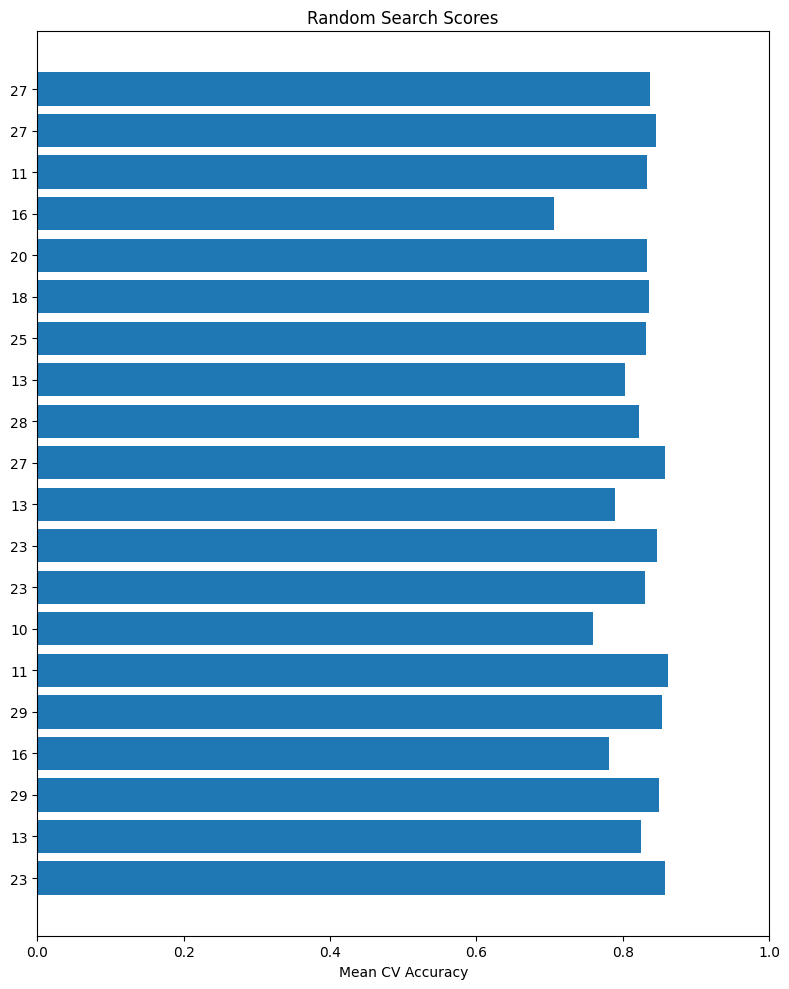

In [36]:
# 하이퍼파라미터 조합별 성능 시각화

# 각 하이퍼파라미터 조합별 교차 검증 스코어 가져오기
results = rs.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# 시각화를 위한 데이터 준비
max_iter_values = [params[i]['max_iter'] for i in range(len(params))]

# 가로 방향으로 막대 그래프로 교차 검증 스코어 시각화
fig, ax = plt.subplots(figsize=(8, 10))
bars = ax.barh(range(len(mean_scores)), mean_scores, tick_label=[f"{compo}" for compo in max_iter_values])
ax.set_xlabel('Mean CV Accuracy')
ax.set_title('Random Search Scores')
plt.xlim((0, 1))
plt.tight_layout()
plt.show()

In [37]:
# best score, best model, train score, test score

sc = rs.best_estimator_
print ("best score : ", rs.best_score_)
print ("best estimator (model) : ", sc)

sc_score = [sc.score(X_train_scaled, y_train), sc.score(X_test_scaled, y_test)]
print (f"train score, test score : {sc_score}")

best score :  0.8625
best estimator (model) :  SGDClassifier(loss='log_loss', max_iter=11)
train score, test score : [0.8597222222222223, 0.8666666666666667]


현재 본 dataset의 feature은 7개이므로, 아래와 같은 linear combination formula를 작성할 수 있다.

$z = w_1 \times f_1 + w_2 \times f_2 +  w_3 \times f_3 +  w_4 \times f_4 +  w_5 \times f_5 +  w_6 \times f_6 +  w_7 \times f_7 + bias$

**결과적으로 7개의 model paramter가 loss function의 global minima에 도달할 때까지 learning rate에 의해 조절되어 가면서, 최적의 weight와 bias를 찾게 되는 것**이다. 이를 조금 더 자세히 구현하고 layer 각각을 디자인하기 위해 Dense를 struction한다. 

-------

### 2. ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 우선, 기존 train set에서 validation set을 하나 더 구성하여 추후 evaluation에 사용할 예정이다.
- 또한 one-hot encoding하여 target값을 0과 1로 구성하고 loss function은 categorical_crossentropy를 사용한다.
    - one-hot encoding하는 방식 중 scikit-learn 내장 메소드인 OneHotEncoder를 사용한다.

#### 2-1) validation set 구성 및 one-hot encoding

In [38]:
# train set에서 validation set을 하나 더 구성

X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train,
                                                               test_size=0.2, 
                                                               stratify=y_train)

print (X_train_scaled.shape, X_val_scaled.shape)

(576, 7) (144, 7)


In [39]:
# one-hot encoding

from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)

print(y_train) # kecimen, Besni 이렇게 두 target이니, 제대로 one-hot encoding된 것을 확인 가능

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### 2-2) modelling, compile, fit

records shape :  (8,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 2)                 16        
                                                                 
Total params: 16 (64.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


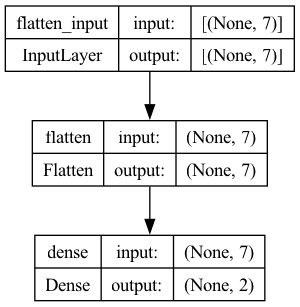

In [40]:
# modelling

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [41]:
# compile

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [42]:
# fit

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=20, 
                   validation_data=(X_val_scaled, y_val))

print (history.history)

Epoch 1/50
29/29 [==============================] - 1s 6ms/step - loss: 0.9903 - accuracy: 0.3993 - val_loss: 1.0219 - val_accuracy: 0.4097
Epoch 2/50
29/29 [==============================] - 0s 2ms/step - loss: 0.9333 - accuracy: 0.4340 - val_loss: 0.9592 - val_accuracy: 0.4236
Epoch 3/50
29/29 [==============================] - 0s 2ms/step - loss: 0.8800 - accuracy: 0.4583 - val_loss: 0.9025 - val_accuracy: 0.4375
Epoch 4/50
29/29 [==============================] - 0s 2ms/step - loss: 0.8310 - accuracy: 0.5017 - val_loss: 0.8501 - val_accuracy: 0.4722
Epoch 5/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7871 - accuracy: 0.5330 - val_loss: 0.7994 - val_accuracy: 0.5208
Epoch 6/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7452 - accuracy: 0.5677 - val_loss: 0.7556 - val_accuracy: 0.5347
Epoch 7/50
29/29 [==============================] - 0s 2ms/step - loss: 0.7084 - accuracy: 0.6111 - val_loss: 0.7142 - val_accuracy: 0.5694
Epoch 8/50
29/29 [==

#### 2-3) loss 시각화 및 evaluate

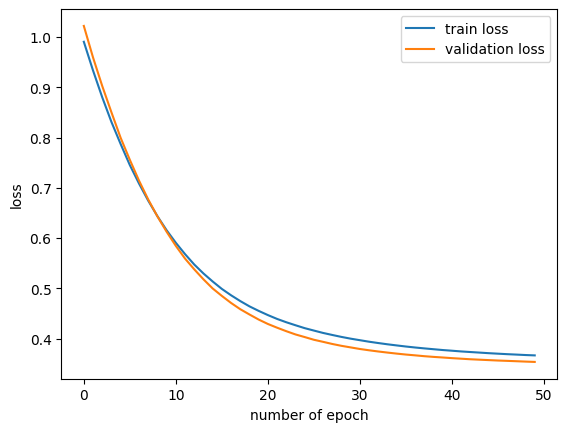

In [43]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

위 그래프를 통해 알 수 있는 사실은 아래와 같다.

- **loss 감소 패턴의 동일성**
  - train loss과 validation loss 모두 에포크가 진행됨에 따라 감소하고 있음
  - loss가 줄어든다 -> accuracy가 상승한다.

- **overfitting 여부**
  - 두 손실 곡선이 비슷한 형태로 감소하고 있고, 검증 손실이 훈련 손실보다 크게 차이나지 않기 때문에, overfitting이 심하게 난다고 볼 수 없음
  - 만약 에포크가 더 진행되면 overfitting 발생할 가능성도 있음

- **모델 복잡도**
  - **ANN 모델의 파라미터가 16개밖에 되지 않기 때문에 매우 간단**한 모델
  - 간단한 모델이기 때문에, 학습이 잘 이루어지고 validation data set에 대한 일반화 성능도 준수한 것


In [44]:
# evaluate

model.evaluate(X_val_scaled, y_val)

5/5 [==============================] - 0s 1ms/step - loss: 0.3538 - accuracy: 0.8611


[0.35378313064575195, 0.8611111044883728]

-------

### 3. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - parameter는 최소한 15000개 이상으로 증폭, 각 node의 activation은 relu 사용
    - epoch는 30으로 고정
- 아래와 같이 experiment할 예정이다.
    - **(1) hidden layer을 추가하여 DNN 구성**
        - (1) 기본 경사 하강법
            - (1-1-1) optimizer : SGD
            - (1-1-2) optimizer : momentum optimization
            - (1-1-3) optimizer : nesterov momentum optimization
            - (1-1-4) 시각화 및 비교
        - (2) 적응적 학습율
            - (1-2-1) optimizer : RMSprop (기본값)
            - (1-2-2) optimizer : Adagrad
            - (1-2-3) optimizer : Adam
            - (1-2-4) 시각화 및 비교
    - **(2) validation loss 감소를 위한 시도**
        - (1) dropout
        - (2) callback : early stopping

#### 2-1) hidden layer를 추가하여 DNN 구성

records shape :  (8,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 256)               2048      
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
Total params: 21138 (82.57 KB)
T

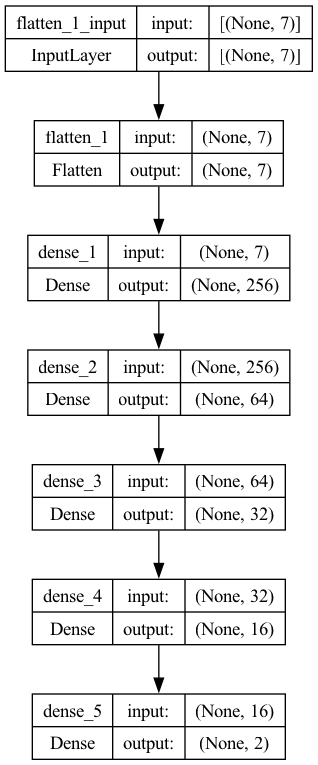

In [45]:
# modelling DNN

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

#### 2-1-1) 기본 경사 하강법
##### (1-1-1) optimizer : SGD

In [46]:
# compile, fit

sgd = keras.optimizers.SGD()
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.6761 - accuracy: 0.7049 - val_loss: 0.6624 - val_accuracy: 0.7500
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6529 - accuracy: 0.7969 - val_loss: 0.6374 - val_accuracy: 0.7639
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6270 - accuracy: 0.8073 - val_loss: 0.6114 - val_accuracy: 0.7778
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.6016 - accuracy: 0.8073 - val_loss: 0.5853 - val_accuracy: 0.7917
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5753 - accuracy: 0.8125 - val_loss: 0.5586 - val_accuracy: 0.8125
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5474 - accuracy: 0.8264 - val_loss: 0.5313 - val_accuracy: 0.8194
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.5184 - accuracy: 0.8420 - val_loss: 0.5036 - val_accuracy: 0.8194
Epoch 8/30
32/32 [==

In [47]:
# evaluate

sgd_score = model.evaluate(X_val_scaled, y_val)
print (sgd_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.3465 - accuracy: 0.8611
[0.3465438783168793, 0.8611111044883728]


##### (1-1-2) optimizer : momentum optimization

In [48]:
# compile, fit

sgd = keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.3316 - accuracy: 0.8733 - val_loss: 0.3487 - val_accuracy: 0.8542
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3272 - accuracy: 0.8733 - val_loss: 0.3484 - val_accuracy: 0.8472
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3227 - accuracy: 0.8733 - val_loss: 0.3357 - val_accuracy: 0.8611
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3236 - accuracy: 0.8750 - val_loss: 0.3570 - val_accuracy: 0.8333
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3218 - accuracy: 0.8715 - val_loss: 0.3495 - val_accuracy: 0.8333
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3114 - accuracy: 0.8715 - val_loss: 0.3563 - val_accuracy: 0.8403
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.3043 - accuracy: 0.8750 - val_loss: 0.3419 - val_accuracy: 0.8542
Epoch 8/30
32/32 [==

In [49]:
# evaluate

momentum_score = model.evaluate(X_val_scaled, y_val)
print (momentum_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.3512 - accuracy: 0.8264
[0.35116761922836304, 0.8263888955116272]


##### (1-1-3) optimizer : nesterov momentum optimization

In [50]:
# compile, fit

sgd = keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2565 - accuracy: 0.9045 - val_loss: 0.3815 - val_accuracy: 0.8264
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.8924 - val_loss: 0.3670 - val_accuracy: 0.8403
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2610 - accuracy: 0.8941 - val_loss: 0.4034 - val_accuracy: 0.8125
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2621 - accuracy: 0.9045 - val_loss: 0.3491 - val_accuracy: 0.8333
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.8976 - val_loss: 0.3666 - val_accuracy: 0.8194
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.8976 - val_loss: 0.3656 - val_accuracy: 0.8333
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2578 - accuracy: 0.8976 - val_loss: 0.3909 - val_accuracy: 0.8333
Epoch 8/30
32/32 [==

In [51]:
# evaluate

nesterov_score = model.evaluate(X_val_scaled, y_val)
print (nesterov_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.8264
[0.4318329989910126, 0.8263888955116272]


##### (1-1-4) 시각화 및 비교

[0.3465438783168793, 0.35116761922836304, 0.4318329989910126, 0.8611111044883728, 0.8263888955116272, 0.8263888955116272]


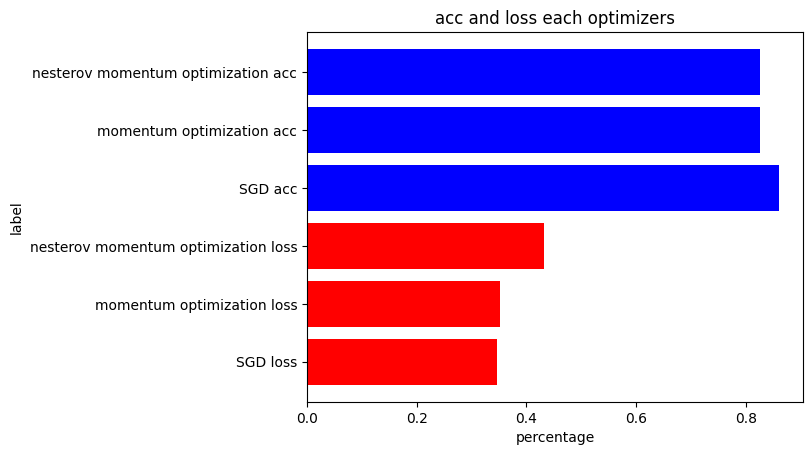

In [52]:
# visualization

labels = [
    'SGD loss',
    'momentum optimization loss',
    'nesterov momentum optimization loss',
    'SGD acc',
    'momentum optimization acc',
    'nesterov momentum optimization acc',
]

scores = [compo[0] for compo in [sgd_score, momentum_score, nesterov_score]] + [compo[1] for compo in [sgd_score, momentum_score, nesterov_score]]
print (scores)

plt.barh(labels, scores, color=['red' for i in range(3)] + ['blue' for i in range (3)])

plt.xlabel('percentage')
plt.ylabel('label')
plt.title('acc and loss each optimizers')

plt.show()

위 figure을 보고 다음과 같은 사실을 유추 가능하다.
- 매우 정석적인 수치가 나옴.
- **loss**
    - 예상대로, SGD의 loss값이 가장 많고, nesterov의 loss 값이 가장 적다.
- **acc**
    - 놀라운 건, 가장 간단해보이는 SGD의 acc가 가장 높다.

#### 2-1-2) 적응적 학습율
- 전에 보았던 learning rate는 전부 기본값 0.01로 고정된 채 SGD를 내부적으로 진행한 것
- 모델이 global minima에 가까이 갈 수록 learning rate를 낮추는 optimizer를 사용하면 전보다 더 나은 성능을 보일 수 있을 것이라고 생각한다
<br>

##### (2-1-1) optimizer : RMSprop

In [53]:
# compile, fit

rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2545 - accuracy: 0.9010 - val_loss: 0.4619 - val_accuracy: 0.8333
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2473 - accuracy: 0.9080 - val_loss: 0.3901 - val_accuracy: 0.8333
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2367 - accuracy: 0.9115 - val_loss: 0.4488 - val_accuracy: 0.8125
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2344 - accuracy: 0.9167 - val_loss: 0.3995 - val_accuracy: 0.8542
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2366 - accuracy: 0.9149 - val_loss: 0.4142 - val_accuracy: 0.8333
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2357 - accuracy: 0.9149 - val_loss: 0.3564 - val_accuracy: 0.8403
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2388 - accuracy: 0.9132 - val_loss: 0.4036 - val_accuracy: 0.8403
Epoch 8/30
32/32 [==

In [54]:
# evaluate

rmsprop_score = model.evaluate(X_val_scaled, y_val)
print (rmsprop_score)

5/5 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.8056
[0.5537110567092896, 0.8055555820465088]


##### (2-1-2) optimizer : Adagrad

In [55]:
# compile, fit

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.1941 - accuracy: 0.9236 - val_loss: 0.5312 - val_accuracy: 0.8125
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9323 - val_loss: 0.5213 - val_accuracy: 0.8264
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9358 - val_loss: 0.5150 - val_accuracy: 0.8264
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1815 - accuracy: 0.9375 - val_loss: 0.5104 - val_accuracy: 0.8264
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9358 - val_loss: 0.5071 - val_accuracy: 0.8333
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1800 - accuracy: 0.9392 - val_loss: 0.5053 - val_accuracy: 0.8333
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.9427 - val_loss: 0.5032 - val_accuracy: 0.8333
Epoch 8/30
32/32 [==

In [56]:
# evaluate

adagrad_score = model.evaluate(X_val_scaled, y_val)
print (adagrad_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.5007 - accuracy: 0.8333
[0.5007010698318481, 0.8333333134651184]


##### (2-1-3) optimizer : Adam

In [57]:
# compile, fit

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_val_scaled, y_val), batch_size=18)

print (history)

Epoch 1/30
32/32 [==============================] - 1s 5ms/step - loss: 0.2159 - accuracy: 0.9167 - val_loss: 0.5266 - val_accuracy: 0.8333
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2098 - accuracy: 0.9167 - val_loss: 0.5881 - val_accuracy: 0.8194
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.9236 - val_loss: 0.4313 - val_accuracy: 0.8333
Epoch 4/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.9306 - val_loss: 0.4583 - val_accuracy: 0.8472
Epoch 5/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9323 - val_loss: 0.4827 - val_accuracy: 0.8333
Epoch 6/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1902 - accuracy: 0.9271 - val_loss: 0.5434 - val_accuracy: 0.8403
Epoch 7/30
32/32 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.9271 - val_loss: 0.5290 - val_accuracy: 0.8125
Epoch 8/30
32/32 [==

In [58]:
# evaluate

adam_score = model.evaluate(X_val_scaled, y_val)
print (adam_score)

5/5 [==============================] - 0s 1ms/step - loss: 0.5250 - accuracy: 0.8194
[0.5250211358070374, 0.8194444179534912]


##### (2-1-4) 시각화 및 비교

[0.5537110567092896, 0.5007010698318481, 0.5250211358070374, 0.8055555820465088, 0.8333333134651184, 0.8194444179534912]


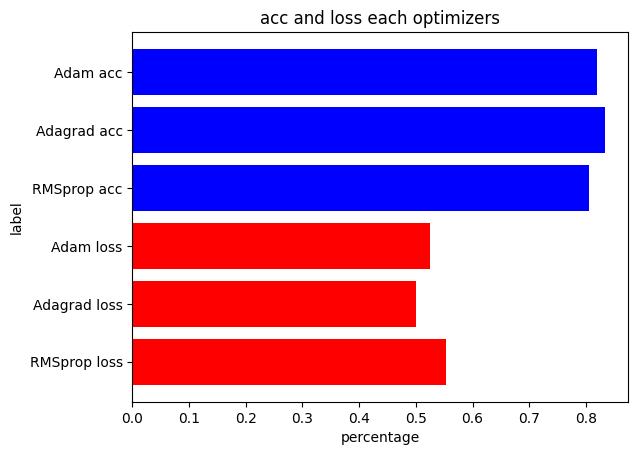

In [59]:
# visualization

labels = [
    'RMSprop loss',
    'Adagrad loss',
    'Adam loss',
    'RMSprop acc',
    'Adagrad acc',
    'Adam acc',
]

scores = [compo[0] for compo in [rmsprop_score, adagrad_score, adam_score]] + [compo[1] for compo in [rmsprop_score, adagrad_score, adam_score]]
print (scores)

plt.barh(labels, scores, color=['red' for i in range(3)] + ['blue' for i in range (3)])

plt.xlabel('percentage')
plt.ylabel('label')
plt.title('acc and loss each optimizers')

plt.show()

위 figure을 보고 다음과 같은 사실을 유추 가능하다.
- **Adagrad의 acc가 가장 높으며, loss도 가장 낮다**
- Adam의 loss가 가장 높으며, Adagrad의 loss가 가장 낮다. 

동일선상에서 비교하였을 때, 현재 dataset에서의 optimizer는 **adagrad가 적합**하다고 볼 수 있다. 따라서 추후 validation loss 감소를 위한 시도 때에서의 model optimizer는 adagrad를 사용할 것이다.

#### 2-2) validation loss 감소를 위한 시도

```sh
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 flatten_6 (Flatten)         (None, 7)                 0         
                                                                 
 dense_10 (Dense)            (None, 256)               2048      
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 2)                 34        
                                                                 
=================================================================
```
- validation loss 감소를 위하여 아래와 같은 방법을 시도해 볼 것이다.
    - **dropout** 
        - 위 figure를 보았을 때, dense_11에서 param이 가장 많이 밀집된 것을 확인 가능하다. 따라서 여기서 30%의 dropout을 하여 특정 노드의 의존성을 해제하겠다.
    - **early stopping**
        - 5번 연속 검증 점수가 향상되지 않을 시 훈련을 중지할 것이다.

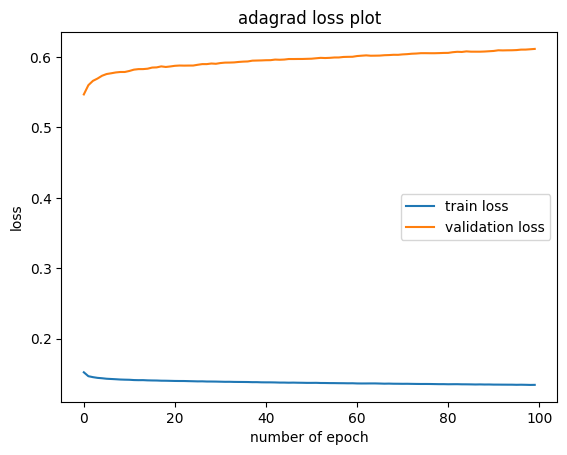

In [60]:
# optimizer인 adagrad를 이용한 compile, fit 및 loss 시각화
# 여기에선 epoch를 100으로 늘려 fit한다.

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=18, verbose=0)

plt.title('adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

**일단 되게 난감한 상황인게, validation loss가 epoch가 늘어남에 따라서 계속적으로 우상향하고 있다.** 이는 즉 학습을 거듭할 수록 overfitting되어가고 있다는 의미인데, 이를 해결하기 위하여 dropout해보자.

##### (2-2-1) dropout

records shape :  (8,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 7)                 0         
                                                                 
 dense_6 (Dense)             (None, 256)               2048      
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (No

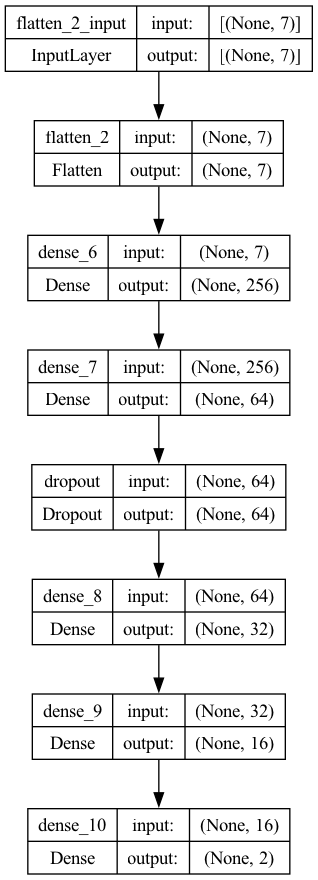

In [61]:
# modelling DNN + dropout

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(7, )), 
    keras.layers.Dense(256, activation='relu'), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),  # dropout 층 추가
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(2, activation='sigmoid')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

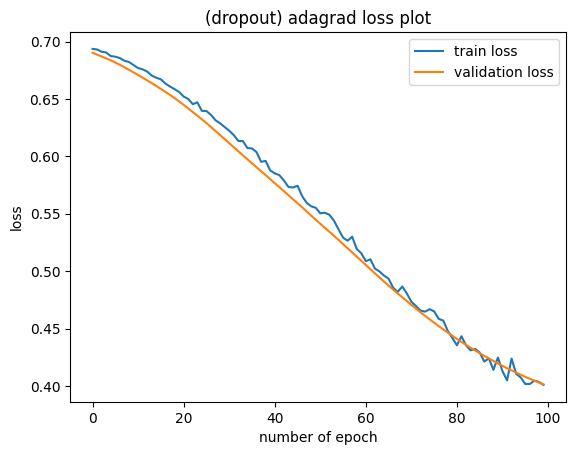

In [62]:
# 재학습 및 재시각화

adagrad = keras.optimizers.Adagrad()
model.compile(optimizer=adagrad, loss='binary_crossentropy', metrics='accuracy')
history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val), batch_size=18, verbose=0)

plt.title('(dropout) adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()

**overfitting을 막았다.** validation loss는 완벽한 우하향 곡선을 띄고 있는데, 계속적으로 감소하고 있으며 음의 무한대로 발산하고 있다.

##### (2-2-2) early stopping

In [65]:
# ModelCheckpoint와 EarlyStopping 메소드를 차례대로 사용하여 구현

model.compile(loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('./model/classification_raisin_model_best.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val),
                   callbacks=[checkpoint_cb, early_stopping_cb], verbose=0)

print ("best epochs : ", early_stopping_cb.stopped_epoch)

best epochs :  6


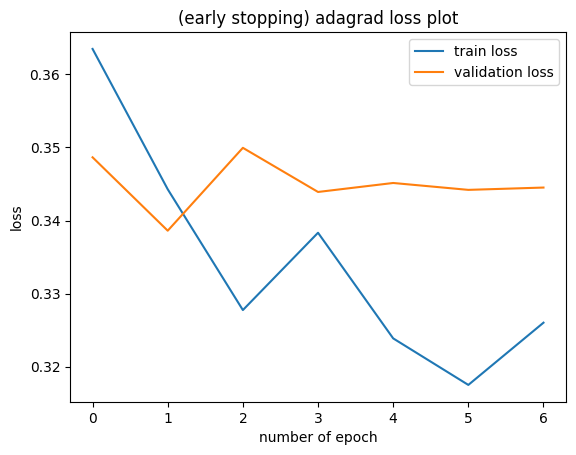

In [66]:
# 시각화

plt.title('(early stopping) adagrad loss plot')
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.xlabel ('number of epoch')
plt.ylabel ('loss')
plt.legend(['train loss', 'validation loss'])

plt.show()